In [1]:
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
#import cftime
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as cx
import re

from pathlib import Path
import pathlib

In [2]:
country = 'GEO'

In [3]:
damage_data_path = Path('C://Users/snn490/OneDrive - Vrije Universiteit Amsterdam/WorldBank_Projects/SupplyChainECA/asset_damages/{}'.format(country))
eq_damage_data_path = damage_data_path / 'fluvial'

admin_path = Path('C:\\Users/snn490/OneDrive - Vrije Universiteit Amsterdam\WorldBank_Projects\SupplyChainECA\data\gadm')
#figures_path = damage_data_path / 'fluvial_figures'

In [4]:
subnational = gpd.read_file(admin_path / 'gadm41_{}.gpkg'.format(country), layer=2)
subnational = subnational.to_crs(3857)

In [5]:
def calculate_risk(road_segment, damages_dict):
    damages_lst = [damages_dict[rp][damages_dict[rp]['osm_id'] == road_segment]['Partial destruction (0.5)'].iloc[0] for rp in [*damages_dict]]
    asset_dam_df = pd.DataFrame([1/rp for rp in [*damages_dict]]+[1,1e-10],damages_lst+[0, max(damages_lst)]).reset_index()
    asset_dam_df.columns = ['damage','prob']
    asset_dam_df = asset_dam_df.sort_values('prob',ascending=True).reset_index(drop=True)
    return np.trapz(asset_dam_df.damage.values,asset_dam_df.prob.values) #np.trapz(y,x)

def calculate_risk_vectorized(row):
    damages_lst = row.values
    rps = row.index
    if isinstance((row.index)[0], str): rps = [int(s) for con_rp in rps for s in re.findall(r'\d+', con_rp)]
    prob_values = np.array([1/rp for rp in rps] + [1, 1e-10])
    damage_values = np.append(damages_lst, [0, max(damages_lst)])
    sorted_indices = np.argsort(prob_values)
    prob_values = prob_values[sorted_indices]
    damage_values = damage_values[sorted_indices]
    return np.trapz(damage_values, prob_values)

def get_province(road_segment,subnational):
    try:
        column_names = subnational.columns
        if 'GID_3' in column_names:
            return subnational.loc[road_segment.geometry.intersects(subnational.geometry)].GID_3.values[0]
        elif 'GID_2' in column_names:
            return subnational.loc[road_segment.geometry.intersects(subnational.geometry)].GID_2.values[0]
    except:
        return None

def handle_zero_values(ead_df, haz_trig_rp_lst):
    """
    Replaces zero values in higher return periods with the value of the previous lower return period,
    if the lower return period has a non-zero value.

    Parameters:
    ead_df (pd.DataFrame): DataFrame containing the 'ead' columns.
    haz_trig_rp_lst (list): List of return periods corresponding to the 'ead' columns.

    Returns:
    pd.DataFrame: Updated DataFrame with zero values replaced.
    """
    # Extract the relevant columns and convert to numpy array for vectorized operations
    values = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].values

    # Iterate over the columns, starting from the second column
    for i in range(1, values.shape[1]):
        # Replace zeros with the previous column's value
        values[:, i] = np.where(values[:, i] == 0, values[:, i-1], values[:, i])

    # Convert the numpy array back to a DataFrame and update the original DataFrame
    ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = values

    # Extract the relevant columns and convert to numpy array for vectorized operations
    values = ead_df[['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0).values

    # Iterate over the columns, starting from the second column
    for i in range(1, values.shape[1]):
        # Replace zeros with the previous column's value
        values[:, i] = np.where(values[:, i] == 0, values[:, i-1], values[:, i])

    # Convert the numpy array back to a DataFrame and update the original DataFrame
    ead_df[['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = values

    # Extract the relevant columns and convert to numpy array for vectorized operations
    values = ead_df[['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0).values

    # Iterate over the columns, starting from the second column
    for i in range(1, values.shape[1]):
        # Replace zeros with the previous column's value
        values[:, i] = np.where(values[:, i] == 0, values[:, i-1], values[:, i])

    # Convert the numpy array back to a DataFrame and update the original DataFrame
    ead_df[['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = values 
    
    return ead_df

# Fluvial figures

In [13]:
# read parquets per return period
haz_rp_lst = [5, 20, 50, 75, 100, 200, 250, 500, 1000]
road_types_lst = ['motorway', 'unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                  'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]
road_types_lst_remove = []
assump_curves = ['F7.4', 'F7.5', 'F7.6', 'F7.7', 'F7.8', 'F7.9']

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(curve_id) for curve_id in assump_curves] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_rp_lst], geometry='geometry')


for road_type in road_types_lst:
    #create damages_dictionary containing damages for different return periods for asset type
    damages_dict = {key: pd.DataFrame() for key in haz_rp_lst}
    for rp in haz_rp_lst:
        damage_data_path_list = eq_damage_data_path.iterdir()                    
        data_path = [path for path in damage_data_path_list if '1in{}_road_{}'.format(rp,road_type) in str(path)]
        if len(data_path) != 0:
            df = gpd.read_parquet(data_path[0])
            damages_dict[rp] = pd.concat([damages_dict[rp], df], ignore_index=True)  #create dictionary with the return period 
            for curve_id in assump_curves: damages_dict[rp] = damages_dict[rp].rename(columns={curve_id: f"{curve_id}_{rp}"}) # Rename the curve_id column in the damages_dict[rp] DataFrame
        else:
            print('No data for {}'.format(road_type))
            road_types_lst_remove.append(road_type)






In [14]:
    if road_type not in road_types_lst_remove:
        #calculate EAD
        osm_id_columns = [df['osm_id'] for df in damages_dict.values()] # Get all 'osm_id' columns from the DataFrames in damages_dict
        if all(df.equals(osm_id_columns[0]) for df in osm_id_columns): # Compare all 'osm_id' columns
            print("All osm_id columns are equal: True")
            temp_df = damages_dict[haz_rp_lst[0]][['osm_id', 'asset', 'geometry']]
            #temp_df = temp_df[0:2]
            print('These are the damages per return period for {}'.format(road_type))
            for curve_id in assump_curves:
                temp_df_curve = temp_df[['osm_id']]
                for rp in haz_rp_lst: #print(damages_dict[rp][['osm_id', f"{curve_id}_{rp}"]])
                    temp_df_curve = temp_df_curve.merge(damages_dict[rp][['osm_id', f"{curve_id}_{rp}"]], on='osm_id', how='left')
                temp_df_curve.set_index('osm_id', inplace=True)
                temp_df_curve.columns = temp_df_curve.columns.str.replace(f"{curve_id}_", '', regex=False)
                temp_df.loc[:, ['ead_{}'.format(curve_id)]] = temp_df.apply(lambda row: calculate_risk_vectorized(temp_df_curve.loc[row['osm_id']]) if row['osm_id'] in temp_df_curve.index else np.nan, axis=1)
                for rp in haz_rp_lst: print("The damage for a {} year return event following curve {}: {:,.2f}".format(rp, curve_id, temp_df_curve['{}'.format(rp)].sum()))
            ead_df = pd.concat([ead_df, temp_df], ignore_index=True)  #create dictionary with the return period 
        
        else:
            temp_df = pd.concat([damages_dict[rp][['osm_id', 'asset', 'geometry']] for rp in damages_dict.keys()]).drop_duplicates(subset=['osm_id']) #merge dataframes into one and remove duplicates based on id_number 
            print("osm_id columns are not equal")

All osm_id columns are equal: True
These are the damages per return period for track


KeyError: "['F7.4_5'] not in index"

In [10]:
damages_dict

{5:          osm_id     asset                     name maxspeed lanes   surface  \
 0      20566560  motorway  თბილისი-სენაკი-ლესელიძე     None     2   asphalt   
 1      20567007  motorway  თბილისი-სენაკი-ლესელიძე      110     2   asphalt   
 2      20567017  motorway  თბილისი-სენაკი-ლესელიძე      110     2   asphalt   
 3      20567984  motorway  თბილისი-სენაკი-ლესელიძე      110     2   asphalt   
 4      20567989  motorway  თბილისი-სენაკი-ლესელიძე       70     2   asphalt   
 ..          ...       ...                      ...      ...   ...       ...   
 686  1295660445  motorway      თბილისი-წითელი ხიდი      110     2  concrete   
 687  1295660446  motorway      თბილისი-წითელი ხიდი      110     2  concrete   
 688  1295660447  motorway      რუსთავის გზატკეცილი      110     2   asphalt   
 689  1295660448  motorway      რუსთავის გზატკეცილი      110     2  concrete   
 690  1295660449  motorway      რუსთავის გზატკეცილი      110     2   asphalt   
 
                                   

In [38]:
ead_df

osm_id     asset  \
0         20566560  motorway   
1         20567007  motorway   
2         20567017  motorway   
3         20567984  motorway   
4         20567989  motorway   
...            ...       ...   
175899  1298785347     track   
175900  1298785348     track   
175901  1298785350     track   
175902  1298785351     track   
175903  1298785353     track   

                                                 geometry       ead_E7.1  \
0       LINESTRING (44.72602 41.87428, 44.72530 41.875...   69483.825657   
1       LINESTRING (44.72585 41.87421, 44.72697 41.87289)   25057.595621   
2       LINESTRING (44.72979 41.83775, 44.73004 41.839...   71656.119432   
3       LINESTRING (44.75820 41.81951, 44.75769 41.819...  191522.201303   
4       LINESTRING (44.73596 41.82664, 44.73594 41.827...   46293.635614   
...                                                   ...            ...   
175899  LINESTRING (43.87663 42.02430, 43.87629 42.022...    4357.750608   
175900  LINESTRING (43.87612 42.02207, 43.87659 42.021...    1408.363905   
175901  LINESTRING (43.87731 42.02038, 43.87729 42.020...    2223.473205   
175902  LINESTRING (43.87456 42.01946, 43.87444 42.018...    5963.924663   
175903  LINESTRING (43.91256 42.03710, 43.91252 42.037...    6246.401959   

             ead_E7.6       ead_E7.7       ead_E7.8       ead_E7.9  \
0        61983.952571   65481.239094   54709.085611  115174.828514   
1        22352.954862   23614.163361   19729.456908   41534.907605   
2        65620.547314   68797.625147   55530.300346  123595.574439   
3       175390.347285  183882.028739  148421.173873  330345.777522   
4        42394.337431   44446.897417   35875.505262   79849.265241   
...               ...            ...            ...            ...   
175899    4475.539771    4544.579523    3207.994550    8753.276489   
175900    1446.431711    1468.744391    1036.778865    2828.936249   
175901    2283.573259    2318.799699    1636.828393    4466.220645   
175902    6125.128402    6219.614736    4390.393011   11979.547759   
175903    6415.241005    6514.202621    4598.341034   12546.951013   

            ead_E7.10      ead_E7.11      ead_E7.12      ead_E7.13  \
0       141391.881597  238721.426558   52421.200074   64025.852276   
1        50989.428975   86088.883511   18904.388482   23089.314678   
2       149849.981221  266703.817665   55424.609107   68488.737121   
3       400518.455315  712844.941372  148138.682736  183056.434006   
4        96810.997895  172304.744520   35807.223143   44247.339447   
...               ...            ...            ...            ...   
175899    9938.797229   21874.406897    3778.760540    4885.626225   
175900    3212.079932    7069.501651    1221.242432    1578.965904   
175901    5071.113820   11161.069549    1928.052696    2492.813375   
175902   13602.026193   29936.847357    5171.531188    6686.363988   
175903   14246.277051   31354.786076    5416.477298    7003.059138   

            ead_E7.14 ead_475_overlay ead_2475_overlay  
0        82024.154114             NaN              NaN  
1        29579.949946             NaN              NaN  
2        88459.664439             NaN              NaN  
3       236434.651977             NaN              NaN  
4        57149.612686             NaN              NaN  
...               ...             ...              ...  
175899    6489.736568             NaN              NaN  
175900    2097.391879             NaN              NaN  
175901    3311.285263             NaN              NaN  
175902    8881.715236             NaN              NaN  
175903    9302.391728             NaN              NaN  

[175904 rows x 15 columns]

In [25]:
temp_df_curve.loc['632191448']

475     5.852892e+06
2475    1.595102e+07
Name: 632191448, dtype: float64

In [26]:

    damages_lst = [5.852892e+06,  1.595102e+07]
    rps = [475, 2475]
    #if isinstance((row.index)[0], str): rps = [int(s) for con_rp in rps for s in re.findall(r'\d+', con_rp)]
    prob_values = np.array([1/rp for rp in rps] + [1, 1e-10])
    damage_values = np.append(damages_lst, [0, max(damages_lst)])
    sorted_indices = np.argsort(prob_values)
    prob_values = prob_values[sorted_indices]
    damage_values = damage_values[sorted_indices]
    print(np.trapz(damage_values, prob_values))


2945276.5716319047


In [27]:
 prob_values

array([1.00000000e-10, 4.04040404e-04, 2.10526316e-03, 1.00000000e+00])

In [28]:
damage_values

array([15951020., 15951020.,  5852892.,        0.])

In [15]:
ead_df[ead_df['ead_E7.1'] == ead_df['ead_{}'.format(curve_id)].max()]

osm_id     asset  \
116846  632191448  motorway   

                                                 geometry      ead_E7.1  \
116846  LINESTRING (4939494.494 5161452.479, 4938886.1...  2.945277e+06   

       ead_475_overlay ead_2475_overlay  
116846             NaN              NaN

In [39]:
ead_df = ead_df.to_crs(3857)

for curve_id in assump_curves:
    print('This is the EAD for earthquakes using curve {}: {:,}'.format(curve_id, ead_df['ead_{}'.format(curve_id)].sum()))
    print('This is the max EAD for road segment using curve {}: {:,}'.format(curve_id, ead_df['ead_{}'.format(curve_id)].max()))

This is the EAD for earthquakes using curve E7.1: 1,365,965,041.3183212
This is the max EAD for road segment using curve E7.1: 2,945,276.6407207544
This is the EAD for earthquakes using curve E7.6: 1,412,931,359.050353
This is the max EAD for road segment using curve E7.6: 2,616,084.8346200683
This is the EAD for earthquakes using curve E7.7: 1,431,163,329.1682208
This is the max EAD for road segment using curve E7.7: 2,767,187.91135261
This is the EAD for earthquakes using curve E7.8: 1,011,589,318.0203397
This is the max EAD for road segment using curve E7.8: 2,327,139.641619701
This is the EAD for earthquakes using curve E7.9: 2,751,153,025.7888594
This is the max EAD for road segment using curve E7.9: 4,846,386.597320124
This is the EAD for earthquakes using curve E7.10: 3,091,624,054.190541
This is the max EAD for road segment using curve E7.10: 5,958,159.776520247
This is the EAD for earthquakes using curve E7.11: 6,969,694,834.820349
This is the max EAD for road segment using cu

In [23]:
subnational_df = gpd.read_file(admin_path / 'gadm41_{}.gpkg'.format(country),layer=2)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_2'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational_df), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_2','ead_E7.6']].groupby('GID_2').sum(),left_on='GID_2',right_index=True)
subnational_df[['NAME_2','ead_E7.6']].groupby('NAME_2').sum().sort_values(by='ead_E7.6',ascending=False)

ead_E7.6
NAME_2                 
Mtskheta   4.938773e+06
Gori       4.510371e+06
Oni        4.146124e+06
Gardabani  4.015526e+06
Dusheti    3.958660e+06
...                 ...
Lagodekhi  3.686503e+05
Abasha     2.975223e+05
Gagra      2.472553e+05
Keda       1.697465e+05
Kutaisi    1.137471e+03

[69 rows x 1 columns]

In [28]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,1e5,1e6,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$100,000','\\$100,000-$1,000,000','> $1,000,000'])

fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

#plt.savefig(figures_path /'landslide_eq_EAD_municipal.png', bbox_inches='tight', dpi=300)

AttributeError: 'GeoDataFrame' object has no attribute 'ead'

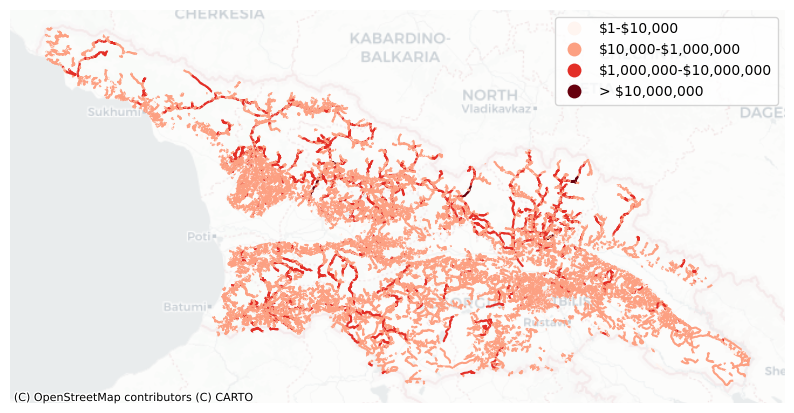

In [41]:
# figure 1/1000 landslide events given a 475 year eq-RP: damages per OSM road segment
damages_dict[1000]['binned'] = pd.cut(damages_dict[1000]['Partial destruction (0.5)'],[0,1e4,1e6,1e7,damages_dict[1000]['Partial destruction (0.5)'].max()],labels=['\\$1-$10,000','\\$10,000-$1,000,000','\\$1,000,000-$10,000,000','> $10,000,000'])
damage_df = damages_dict[1000].to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

damage_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

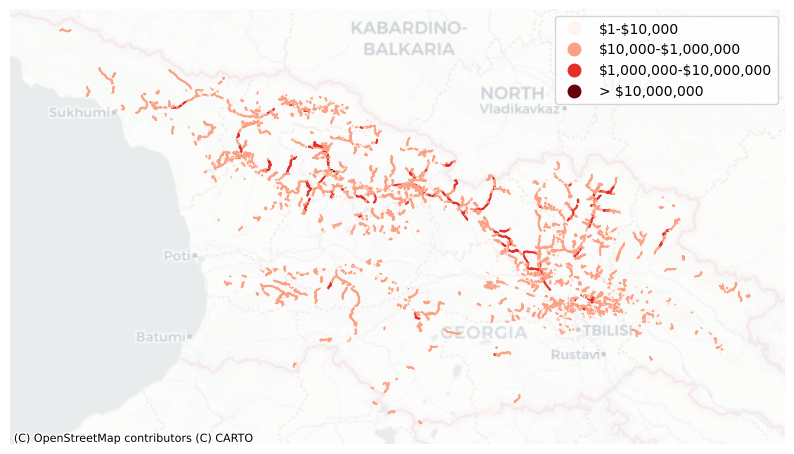

In [42]:
# figure 1/100 landslide events given a 475 year eq-RP: damages per OSM road segment
damages_dict[100]['binned'] = pd.cut(damages_dict[100]['Partial destruction (0.5)'],[0,1e4,1e6,1e7,damages_dict[1000]['Partial destruction (0.5)'].max()],labels=['\\$1-$10,000','\\$10,000-$1,000,000','\\$1,000,000-$10,000,000','> $10,000,000'])
damage_df = damages_dict[100].to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

damage_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

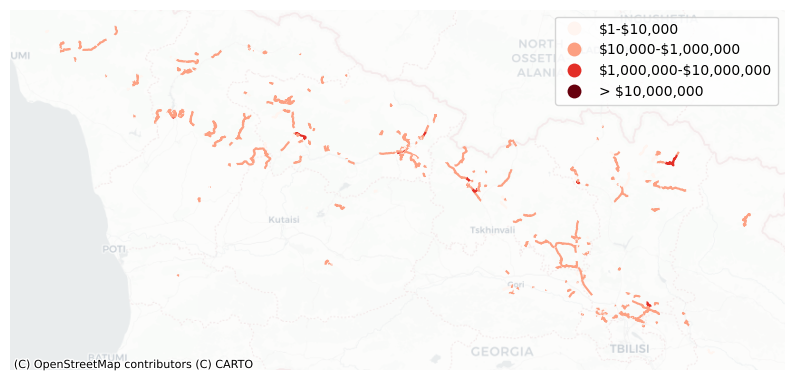

In [43]:
# figure 1/20 landslide events given a 475 year eq-RP: damages per OSM road segment
damages_dict[20]['binned'] = pd.cut(damages_dict[20]['Partial destruction (0.5)'],[0,1e4,1e6,1e7,damages_dict[1000]['Partial destruction (0.5)'].max()],labels=['\\$1-$10,000','\\$10,000-$1,000,000','\\$1,000,000-$10,000,000','> $10,000,000'])
damage_df = damages_dict[20].to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

damage_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

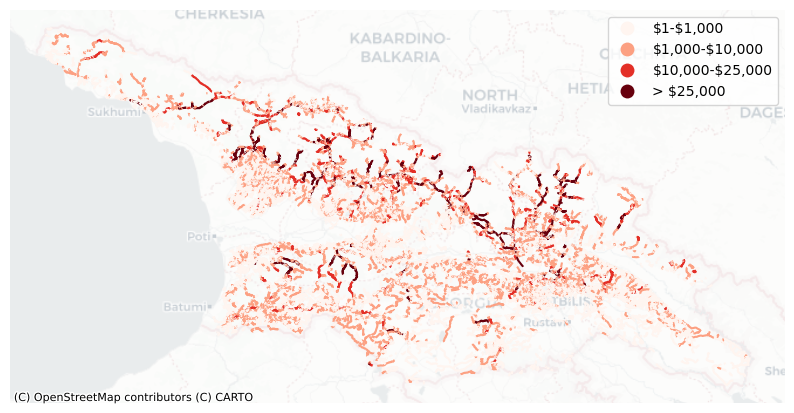

In [44]:
# figure EAD due to earthquake-triggered landslide events given a 475 year eq-RP: damages per OSM road segment
ead_df['ead_475_binned'] = pd.cut(ead_df['ead_475'],[0,1e3,1e4,2.5e4,ead_df['ead_475'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_475_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

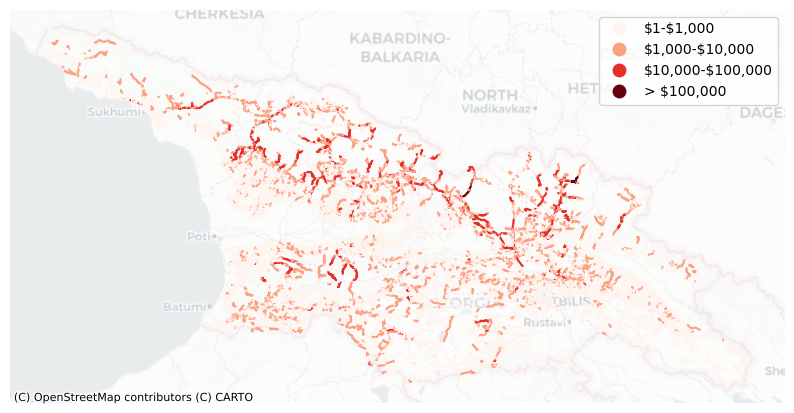

In [62]:
# figure EAD due to earthquake-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,1e5,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$100,000','> $100,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_eq_EAD.png', bbox_inches='tight', dpi=300)

In [61]:
print(ead_df.ead_binned.value_counts())
print(ead_df['ead'].sort_values(ascending=False))

ead_binned
\$1-$1,000            32067
\$1,000-$10,000        2423
\$10,000-$1000,000      277
> $100,000                4
Name: count, dtype: int64
27196     292206.669529
109976    186922.428275
102315    168153.483194
144600    130697.751956
111074     94641.639638
              ...      
65490          0.000000
65493          0.000000
65495          0.000000
65497          0.000000
175212         0.000000
Name: ead, Length: 175213, dtype: float64


In [75]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_475_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_475_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 19067.70
This is the EAD at national level: 18391759.65
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 964.55 dollar per km


# Rainfall-triggered 

## Historical conditions

In [108]:
#read parquets per return period
haz_trig_rp_lst = [5, 25, 200, 1000]
landslide_rp_lst = [5.0, 7.0, 10.0, 20.0, 33.0, 50.0, 100.0]
road_types_lst = ['unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                                'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = his_rainfall_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

#ead_df
for rp_trig in haz_trig_rp_lst:
    if ead_df['ead_{}'.format(rp_trig)].isnull().all(): 
        ead_df = ead_df.drop(['ead_{}'.format(rp_trig), 'ead_{}_overlay'.format(rp_trig), 'ead_{}_number_landslides'.format(rp_trig)],axis=1)
        haz_trig_rp_lst.remove(rp_trig)
ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 20.0 given rainfall event of 5: 1,110,586.54
This is the total damage for landslide return period 33.0 given rainfall event of 5: 10,735,423.25
This is the total damage for landslide return period 50.0 given rainfall event of 5: 75,801,523.45
This is the total damage for landslide return period 100.0 given rainfall event of 5: 418,841,420.82
Unique osm_id in original data: 174224
Unique osm_id in pivoted data: 174224
Missing osm_id values: set()
This is the total damage for landslide return period 10.0 given rainfall event of 25: 34,782,097.68
This is the total damage for landslide return period 20.0 given rainfall event of 25: 194,891,991.45
This is the total damage for landslide return period 33.0 given rainfall event of 25: 1,452,383,602.19
This is the total damage for landslide return period 50.0 given rainfall event of 25: 7,526,826,624.95
Unique osm_id in original data: 175213
Unique osm_id in pivoted data: 175213
Missing osm_i

In [109]:
ead_df

osm_id        asset  \
0       1000043475        track   
1       1000043476        track   
2       1000043477        track   
3       1000043478        track   
4        100008817  residential   
...            ...          ...   
175208   999991954        track   
175209   999991955     motorway   
175210   999992212     motorway   
175211   999992213     motorway   
175212   999992214     motorway   

                                                 geometry  ead_5  \
0       LINESTRING (41.78766 41.66524, 41.78811 41.665...    0.0   
1       LINESTRING (41.78756 41.66560, 41.78783 41.665...    0.0   
2       LINESTRING (41.77205 41.66187, 41.77202 41.662...    0.0   
3       LINESTRING (41.77172 41.66351, 41.77162 41.663...    0.0   
4       LINESTRING (43.95966 42.21961, 43.95957 42.220...    0.0   
...                                                   ...    ...   
175208  LINESTRING (43.39436 42.09891, 43.39437 42.098...    0.0   
175209  LINESTRING (43.39817 42.09797, 43.39690 42.09833)    0.0   
175210  LINESTRING (43.35103 42.10604, 43.35027 42.106...    0.0   
175211  LINESTRING (43.38671 42.09917, 43.38584 42.099...    0.0   
175212  LINESTRING (43.39660 42.09841, 43.39586 42.09862)    0.0   

              ead_25       ead_200  ead_5_overlay  ead_25_overlay  \
0         452.223204    721.922586            0.0      119.866392   
1         303.642468    484.730447            0.0       80.483546   
2         960.915694   1718.823289            0.0      187.297831   
3        2532.764864   4302.006170            0.0      576.981297   
4           0.000000      0.000000            0.0        0.000000   
...              ...           ...            ...             ...   
175208   1823.358832   2910.783682            0.0      483.299933   
175209    548.126907    875.021871            0.0       21.792998   
175210  15101.100533  24107.178597            0.0      600.405204   
175211   5115.740538   8166.694244            0.0      203.396914   
175212   1060.224024   1692.526307            0.0       42.153485   

        ead_200_overlay  ead_5_number_landslides  ead_25_number_landslides  \
0            119.866392                      0.0                       3.0   
1             80.483546                      0.0                       2.0   
2            187.297831                      0.0                       3.0   
3            576.981297                      0.0                       6.0   
4              0.000000                      0.0                       0.0   
...                 ...                      ...                       ...   
175208       483.299933                      0.0                       5.0   
175209        21.792998                      0.0                       1.0   
175210       600.405204                      0.0                       8.0   
175211       203.396914                      0.0                       3.0   
175212        42.153485                      0.0                       1.0   

        ead_200_number_landslides  
0                             3.0  
1                             2.0  
2                             3.0  
3                             6.0  
4                             0.0  
...                           ...  
175208                        5.0  
175209                        1.0  
175210                        8.0  
175211                        3.0  
175212                        1.0  

[175213 rows x 12 columns]

In [110]:
# Calculate EAD for landslide-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id') #create df with only ead columns
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given rainfall event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for rainfall-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for rainfall-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given rainfall event of 5: 7,751,663.496123953
This is the EAD given rainfall event of 25: 234,410,034.19110712
This is the EAD given rainfall event of 200: 400,158,077.3380545
This is the national EAD for rainfall-triggered landslides: 35579333.511862285
This is the max EAD for rainfall-triggered landslides for a road segment: 282522.70935713156


In [111]:
ead_df 

osm_id        asset  \
0       1000043475        track   
1       1000043476        track   
2       1000043477        track   
3       1000043478        track   
4        100008817  residential   
...            ...          ...   
175208   999991954        track   
175209   999991955     motorway   
175210   999992212     motorway   
175211   999992213     motorway   
175212   999992214     motorway   

                                                 geometry  ead_5  \
0       LINESTRING (4651780.498 5110964.670, 4651830.8...    0.0   
1       LINESTRING (4651769.923 5111018.241, 4651799.8...    0.0   
2       LINESTRING (4650043.436 5110462.358, 4650039.9...    0.0   
3       LINESTRING (4650006.901 5110707.789, 4649995.8...    0.0   
4       LINESTRING (4893567.122 5193932.634, 4893556.4...    0.0   
...                                                   ...    ...   
175208  LINESTRING (4830637.713 5175806.692, 4830639.1...    0.0   
175209  LINESTRING (4831062.453 5175666.836, 4830920.8...    0.0   
175210  LINESTRING (4825814.752 5176876.740, 4825729.7...    0.0   
175211  LINESTRING (4829786.119 5175845.954, 4829689.0...    0.0   
175212  LINESTRING (4830887.971 5175732.203, 4830804.5...    0.0   

              ead_25       ead_200  ead_5_overlay  ead_25_overlay  \
0         452.223204    721.922586            0.0      119.866392   
1         303.642468    484.730447            0.0       80.483546   
2         960.915694   1718.823289            0.0      187.297831   
3        2532.764864   4302.006170            0.0      576.981297   
4           0.000000      0.000000            0.0        0.000000   
...              ...           ...            ...             ...   
175208   1823.358832   2910.783682            0.0      483.299933   
175209    548.126907    875.021871            0.0       21.792998   
175210  15101.100533  24107.178597            0.0      600.405204   
175211   5115.740538   8166.694244            0.0      203.396914   
175212   1060.224024   1692.526307            0.0       42.153485   

        ead_200_overlay  ead_5_number_landslides  ead_25_number_landslides  \
0            119.866392                      0.0                       3.0   
1             80.483546                      0.0                       2.0   
2            187.297831                      0.0                       3.0   
3            576.981297                      0.0                       6.0   
4              0.000000                      0.0                       0.0   
...                 ...                      ...                       ...   
175208       483.299933                      0.0                       5.0   
175209        21.792998                      0.0                       1.0   
175210       600.405204                      0.0                       8.0   
175211       203.396914                      0.0                       3.0   
175212        42.153485                      0.0                       1.0   

        ead_200_number_landslides          ead  
0                             3.0    60.335021  
1                             2.0    40.511576  
2                             3.0   132.362804  
3                             6.0   343.739713  
4                             0.0     0.000000  
...                           ...          ...  
175208                        5.0   243.270119  
175209                        1.0    73.130365  
175210                        8.0  2014.768818  
175211                        3.0   682.535322  
175212                        1.0   141.453684  

[175213 rows x 13 columns]

In [112]:
subnational_df = gpd.read_file(admin_path / 'gadm41_{}.gpkg'.format(country),layer=2)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_2'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational_df), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_2','ead']].groupby('GID_2').sum(),left_on='GID_2',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                   
Dusheti      2.181114e+06
Gagra        1.838741e+06
Mestia       1.773217e+06
Khulo        1.465395e+06
Shuakhevi    1.301217e+06
...                   ...
Marneuli     3.327703e+04
Lagodekhi    3.240513e+04
Ninotsminda  3.546087e+03
Kutaisi      1.346160e+03
Abasha       0.000000e+00

[69 rows x 1 columns]

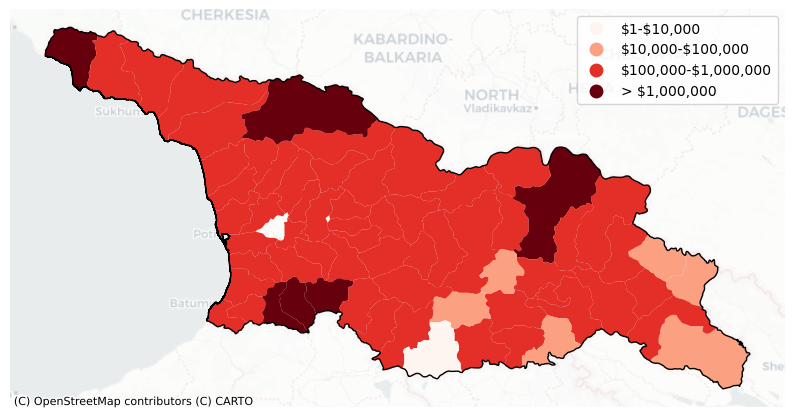

In [113]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,1e5,1e6,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$100,000','\\$100,000-$1,000,000','> $1,000,000'])

fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_historical_EAD_municipal.png', bbox_inches='tight', dpi=300)

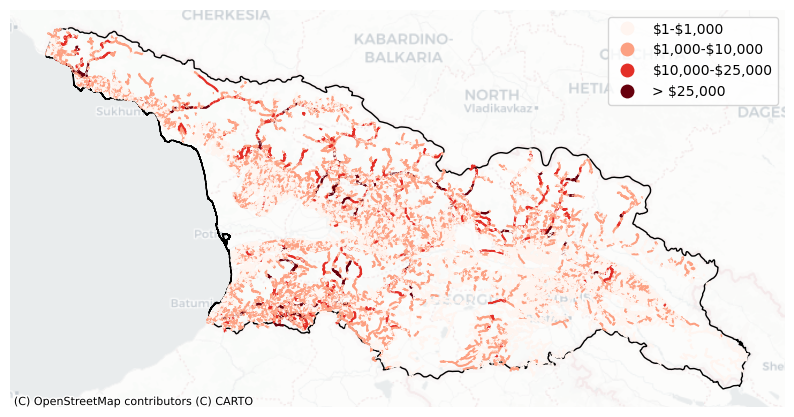

In [114]:
# figure EAD due to rainfall-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_historical_EAD.png', bbox_inches='tight', dpi=300)

In [115]:
print(ead_df.ead_binned.value_counts())
print(ead_df['ead'].sort_values(ascending=False))

ead_binned
\$1-$1,000          53180
\$1,000-$10,000      5734
\$10,000-$25,000      322
> $25,000              95
Name: count, dtype: int64
27196     282522.709357
102315    268993.395674
109976    177821.345878
61645     177282.918977
28365     143392.250768
              ...      
84987          0.000000
84986          0.000000
84985          0.000000
84983          0.000000
103585         0.000000
Name: ead, Length: 175213, dtype: float64


In [117]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_200_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_200_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 33011.83
This is the EAD at national level: 35579333.51
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1077.78 dollar per km


## Future conditions SSP126

In [118]:
#read parquets per return period
haz_trig_rp_lst = [5, 25, 200, 1000]
landslide_rp_lst = [5.0, 7.0, 10.0, 20.0, 33.0, 50.0, 100.0]
road_types_lst = ['primary']

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = fut126_rainfall_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

#ead_df
for rp_trig in haz_trig_rp_lst:
    if ead_df['ead_{}'.format(rp_trig)].isnull().all(): 
        ead_df = ead_df.drop(['ead_{}'.format(rp_trig), 'ead_{}_overlay'.format(rp_trig), 'ead_{}_number_landslides'.format(rp_trig)],axis=1)
        haz_trig_rp_lst.remove(rp_trig)
ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 20.0 given rainfall event of 5: 1,110,586.54
This is the total damage for landslide return period 33.0 given rainfall event of 5: 10,875,160.28
This is the total damage for landslide return period 50.0 given rainfall event of 5: 77,387,451.18
This is the total damage for landslide return period 100.0 given rainfall event of 5: 439,990,837.57
Unique osm_id in original data: 174224
Unique osm_id in pivoted data: 174224
Missing osm_id values: set()
This is the total damage for landslide return period 10.0 given rainfall event of 25: 34,782,097.68
This is the total damage for landslide return period 20.0 given rainfall event of 25: 195,470,870.27
This is the total damage for landslide return period 33.0 given rainfall event of 25: 1,476,786,401.08
This is the total damage for landslide return period 50.0 given rainfall event of 25: 7,844,206,436.04
Unique osm_id in original data: 175213
Unique osm_id in pivoted data: 175213
Missing osm_i

In [119]:
# Calculate EAD for earthquake-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id')
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given rainfall event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for rainfall-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for rainfall-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given rainfall event of 5: 8,087,100.369983716
This is the EAD given rainfall event of 25: 242,778,832.3195557
This is the EAD given rainfall event of 200: 416,059,663.5123421
This is the national EAD for rainfall-triggered landslides: 36914086.71616977
This is the max EAD for rainfall-triggered landslides for a road segment: 282522.70935713156


In [120]:
ead_df 

osm_id        asset  \
0       1000043475        track   
1       1000043476        track   
2       1000043477        track   
3       1000043478        track   
4        100008817  residential   
...            ...          ...   
175208   999991954        track   
175209   999991955     motorway   
175210   999992212     motorway   
175211   999992213     motorway   
175212   999992214     motorway   

                                                 geometry  ead_5  \
0       LINESTRING (4651780.498 5110964.670, 4651830.8...    0.0   
1       LINESTRING (4651769.923 5111018.241, 4651799.8...    0.0   
2       LINESTRING (4650043.436 5110462.358, 4650039.9...    0.0   
3       LINESTRING (4650006.901 5110707.789, 4649995.8...    0.0   
4       LINESTRING (4893567.122 5193932.634, 4893556.4...    0.0   
...                                                   ...    ...   
175208  LINESTRING (4830637.713 5175806.692, 4830639.1...    0.0   
175209  LINESTRING (4831062.453 5175666.836, 4830920.8...    0.0   
175210  LINESTRING (4825814.752 5176876.740, 4825729.7...    0.0   
175211  LINESTRING (4829786.119 5175845.954, 4829689.0...    0.0   
175212  LINESTRING (4830887.971 5175732.203, 4830804.5...    0.0   

              ead_25       ead_200  ead_5_overlay  ead_25_overlay  \
0         452.223204    721.922586            0.0      119.866392   
1         303.642468    484.730447            0.0       80.483546   
2         960.915694   1718.823289            0.0      187.297831   
3        2532.764864   4302.006170            0.0      576.981297   
4           0.000000      0.000000            0.0        0.000000   
...              ...           ...            ...             ...   
175208   1823.358832   2910.783682            0.0      483.299933   
175209    548.126907    875.021871            0.0       21.792998   
175210  15101.100533  24107.178597            0.0      600.405204   
175211   5115.740538   8166.694244            0.0      203.396914   
175212   1060.224024   1692.526307            0.0       42.153485   

        ead_200_overlay  ead_5_number_landslides  ead_25_number_landslides  \
0            119.866392                      0.0                       3.0   
1             80.483546                      0.0                       2.0   
2            187.297831                      0.0                       3.0   
3            576.981297                      0.0                       6.0   
4              0.000000                      0.0                       0.0   
...                 ...                      ...                       ...   
175208       483.299933                      0.0                       5.0   
175209        21.792998                      0.0                       1.0   
175210       600.405204                      0.0                       8.0   
175211       203.396914                      0.0                       3.0   
175212        42.153485                      0.0                       1.0   

        ead_200_number_landslides          ead  
0                             3.0    60.335021  
1                             2.0    40.511576  
2                             3.0   132.362804  
3                             6.0   343.739713  
4                             0.0     0.000000  
...                           ...          ...  
175208                        5.0   243.270119  
175209                        1.0    73.130365  
175210                        8.0  2014.768818  
175211                        3.0   682.535322  
175212                        1.0   141.453684  

[175213 rows x 13 columns]

In [121]:
subnational_df = gpd.read_file(admin_path / 'gadm41_{}.gpkg'.format(country),layer=2)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_2'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational_df), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_2','ead']].groupby('GID_2').sum(),left_on='GID_2',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                   
Dusheti      2.181477e+06
Gagra        1.838741e+06
Mestia       1.773217e+06
Khulo        1.474454e+06
Shuakhevi    1.301217e+06
...                   ...
Ninotsminda  5.012192e+04
Marneuli     3.327703e+04
Lagodekhi    3.240513e+04
Kutaisi      1.346160e+03
Abasha       0.000000e+00

[69 rows x 1 columns]

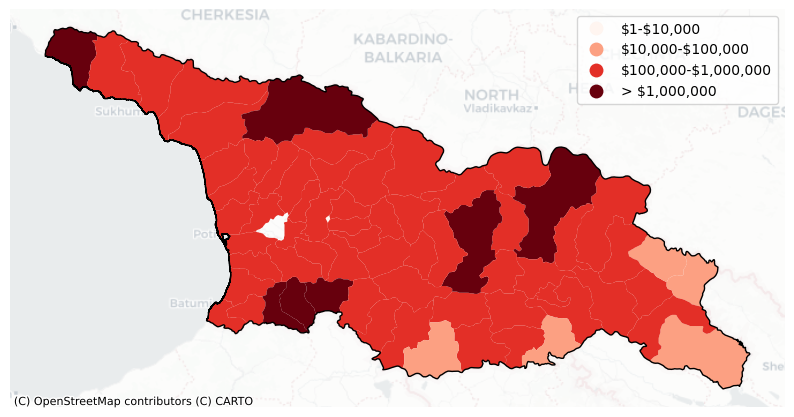

In [122]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,1e5,1e6,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$100,000','\\$100,000-$1,000,000','> $1,000,000'])

fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_SSP126_EAD_municipal.png', bbox_inches='tight', dpi=300)

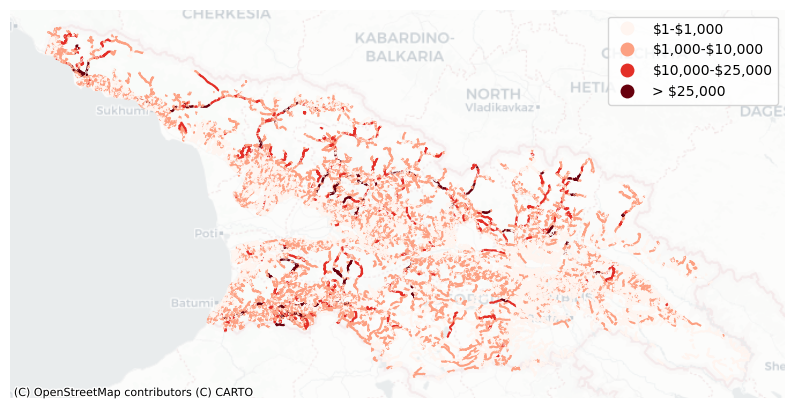

In [123]:
# figure EAD due to rainfall-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_ssp126_EAD.png', bbox_inches='tight', dpi=300)

In [124]:
ead_df.ead.max()

282522.70935713156

In [125]:
ead_df.ead_binned.value_counts()

ead_binned
\$1-$1,000          55165
\$1,000-$10,000      6034
\$10,000-$25,000      327
> $25,000              96
Name: count, dtype: int64

In [127]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_200_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_200_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 34746.06
This is the EAD at national level: 36914086.72
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1062.40 dollar per km


## Future conditions SSP585

In [128]:
#read parquets per return period
haz_trig_rp_lst = [5, 25, 200, 1000]
landslide_rp_lst = [5.0, 7.0, 10.0, 20.0, 33.0, 50.0, 100.0]
road_types_lst = ['primary']

#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_trig_rp_lst] +['ead_{}_number_landslides'.format(rp_trig) for rp_trig in haz_trig_rp_lst], geometry='geometry')

for rp_trig in haz_trig_rp_lst:
    damage_data_path_list = fut585_rainfall_damage_data_path.iterdir()
    rp_trig_path_list = [path for path in damage_data_path_list if '_trig{}'.format(rp_trig) in str(path)]

    damages_dict = {key: pd.DataFrame() for key in landslide_rp_lst}
    for data_path in rp_trig_path_list:
        df = gpd.read_parquet(data_path)
        damages_dict[df['return_period_landslide'].unique()[0]] = pd.concat([damages_dict[df['return_period_landslide'].unique()[0]], df], ignore_index=True)  #create dictionary with the return period 

    #modify dictionaries 
    non_empty_rps = [key for key, df in damages_dict.items() if not df.empty]
    if non_empty_rps:
        lowest_non_empty_rp = min(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key >= lowest_non_empty_rp} # Step 1: Remove all keys above this return period
        highest_non_empty_rp = max(non_empty_rps)
        damages_dict = {key: df for key, df in damages_dict.items() if key <= highest_non_empty_rp} # Step 2: Remove all keys below this return period
        for rp in damages_dict.keys():
            #print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}; exposed roads: {:.2f} km'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum(), damages_dict[rp]['Overlay'].sum()/1000))
            print('This is the total damage for landslide return period {} given rainfall event of {}: {:,.2f}'.format(rp, rp_trig, damages_dict[rp]['Partial destruction (0.5)'].sum()))   
        
        # Calculate EAD per OSM road segment for rainfall event
        combined_df = pd.concat([damages_dict[rp] for rp in damages_dict.keys()]) #merge dataframes into one
        combined_df['Partial destruction (0.5)'] = combined_df['Partial destruction (0.5)'].fillna(0)
        temp_df = combined_df.drop_duplicates(subset=['osm_id']) # remove duplicates
        ead_df = pd.merge(ead_df, temp_df[['osm_id', 'asset', 'geometry']], on=['osm_id', 'asset', 'geometry'], how='outer')
        
        pivoted_damages = combined_df.pivot_table(index='osm_id', columns='return_period_landslide', values='Partial destruction (0.5)', fill_value=0)
        
        print("Unique osm_id in original data:", combined_df['osm_id'].nunique()) # Print unique osm_id from the original DataFrame
        print("Unique osm_id in pivoted data:", pivoted_damages.index.nunique()) # Print unique osm_id from the pivoted DataFrame
        missing_ids = set(combined_df['osm_id']) - set(pivoted_damages.index) # Check if some osm_id values are missing from pivoted_damages
        print("Missing osm_id values:", missing_ids)
        
        ead_df['ead_{}'.format(rp_trig)] = ead_df.apply(lambda row: calculate_risk_vectorized(pivoted_damages.loc[row['osm_id']]) if row['osm_id'] in pivoted_damages.index else 0, axis=1)

        #fill in overlay columns
        overlay_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['Overlay'].to_dict()
        ead_df['ead_{}_overlay'.format(rp_trig)] = ead_df['osm_id'].map(overlay_dict)

        #fill in number of landslides columns
        number_landslide_dict = damages_dict[highest_non_empty_rp].set_index('osm_id')['number of landslides'].to_dict()
        ead_df['ead_{}_number_landslides'.format(rp_trig)] = ead_df['osm_id'].map(number_landslide_dict)

#ead_df
for rp_trig in haz_trig_rp_lst:
    if ead_df['ead_{}'.format(rp_trig)].isnull().all(): 
        ead_df = ead_df.drop(['ead_{}'.format(rp_trig), 'ead_{}_overlay'.format(rp_trig), 'ead_{}_number_landslides'.format(rp_trig)],axis=1)
        haz_trig_rp_lst.remove(rp_trig)
ead_df = handle_zero_values(ead_df, haz_trig_rp_lst) # Handle 0 values for higher return periods with damages for the lower return periods

This is the total damage for landslide return period 20.0 given rainfall event of 5: 1,110,586.54
This is the total damage for landslide return period 33.0 given rainfall event of 5: 10,875,160.28
This is the total damage for landslide return period 50.0 given rainfall event of 5: 77,387,451.18
This is the total damage for landslide return period 100.0 given rainfall event of 5: 439,990,837.57
Unique osm_id in original data: 174224
Unique osm_id in pivoted data: 174224
Missing osm_id values: set()
This is the total damage for landslide return period 10.0 given rainfall event of 25: 55,679,639.80
This is the total damage for landslide return period 20.0 given rainfall event of 25: 272,716,100.19
This is the total damage for landslide return period 33.0 given rainfall event of 25: 1,691,724,216.00
This is the total damage for landslide return period 50.0 given rainfall event of 25: 8,057,225,362.03
Unique osm_id in original data: 175213
Unique osm_id in pivoted data: 175213
Missing osm_i

In [129]:
# Calculate EAD for earthquake-triggered landslides
ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]] = ead_df[['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst]].fillna(0)
temp_df = (ead_df.filter(['osm_id']+['ead_{}'.format(rp_trig) for rp_trig in haz_trig_rp_lst], axis=1)).set_index('osm_id')
ead_df['ead'] = ead_df.apply(lambda row: calculate_risk_vectorized(temp_df.loc[row['osm_id']]), axis=1)
ead_df = ead_df.to_crs(3857)

for rp_trig in haz_trig_rp_lst:
    print('This is the EAD given rainfall event of {}: {:,}'.format(rp_trig, ead_df['ead_{}'.format(rp_trig)].sum()))
print('This is the national EAD for rainfall-triggered landslides: {}'.format(sum(ead_df['ead'])))
print('This is the max EAD for rainfall-triggered landslides for a road segment: {}'.format(max(ead_df['ead'])))

This is the EAD given rainfall event of 5: 8,087,100.369983716
This is the EAD given rainfall event of 25: 263,978,859.99890238
This is the EAD given rainfall event of 200: 446,153,137.93574005
This is the national EAD for rainfall-triggered landslides: 39658192.586423166
This is the max EAD for rainfall-triggered landslides for a road segment: 711893.3911700193


In [130]:
ead_df 

osm_id        asset  \
0       1000043475        track   
1       1000043476        track   
2       1000043477        track   
3       1000043478        track   
4        100008817  residential   
...            ...          ...   
175208   999991954        track   
175209   999991955     motorway   
175210   999992212     motorway   
175211   999992213     motorway   
175212   999992214     motorway   

                                                 geometry  ead_5  \
0       LINESTRING (4651780.498 5110964.670, 4651830.8...    0.0   
1       LINESTRING (4651769.923 5111018.241, 4651799.8...    0.0   
2       LINESTRING (4650043.436 5110462.358, 4650039.9...    0.0   
3       LINESTRING (4650006.901 5110707.789, 4649995.8...    0.0   
4       LINESTRING (4893567.122 5193932.634, 4893556.4...    0.0   
...                                                   ...    ...   
175208  LINESTRING (4830637.713 5175806.692, 4830639.1...    0.0   
175209  LINESTRING (4831062.453 5175666.836, 4830920.8...    0.0   
175210  LINESTRING (4825814.752 5176876.740, 4825729.7...    0.0   
175211  LINESTRING (4829786.119 5175845.954, 4829689.0...    0.0   
175212  LINESTRING (4830887.971 5175732.203, 4830804.5...    0.0   

              ead_25       ead_200  ead_5_overlay  ead_25_overlay  \
0         721.922586   1348.496908            0.0      119.866392   
1         484.730447    905.439893            0.0       80.483546   
2        1128.043753   2107.100597            0.0      187.297831   
3        3309.169777   6105.775160            0.0      576.981297   
4           0.000000      0.000000            0.0        0.000000   
...              ...           ...            ...             ...   
175208   1823.358832   2910.783682            0.0      483.299933   
175209    548.126907    875.021871            0.0       21.792998   
175210  15101.100533  24107.178597            0.0      600.405204   
175211   5115.740538   8166.694244            0.0      203.396914   
175212   1060.224024   1692.526307            0.0       42.153485   

        ead_200_overlay  ead_5_number_landslides  ead_25_number_landslides  \
0            119.866392                      0.0                       3.0   
1             80.483546                      0.0                       2.0   
2            187.297831                      0.0                       3.0   
3            576.981297                      0.0                       6.0   
4              0.000000                      0.0                       0.0   
...                 ...                      ...                       ...   
175208       483.299933                      0.0                       5.0   
175209        21.792998                      0.0                       1.0   
175210       600.405204                      0.0                       8.0   
175211       203.396914                      0.0                       3.0   
175212        42.153485                      0.0                       1.0   

        ead_200_number_landslides          ead  
0                             3.0   100.728632  
1                             2.0    67.633616  
2                             3.0   157.394029  
3                             6.0   460.023994  
4                             0.0     0.000000  
...                           ...          ...  
175208                        5.0   243.270119  
175209                        1.0    73.130365  
175210                        8.0  2014.768818  
175211                        3.0   682.535322  
175212                        1.0   141.453684  

[175213 rows x 13 columns]

In [131]:
subnational_df = gpd.read_file(admin_path / 'gadm41_{}.gpkg'.format(country),layer=2)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_2'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational_df), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_2','ead']].groupby('GID_2').sum(),left_on='GID_2',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

ead
NAME_2                   
Dusheti      2.181477e+06
Lentekhi     1.848155e+06
Gagra        1.838741e+06
Mestia       1.832096e+06
Khulo        1.474454e+06
...                   ...
Ninotsminda  5.527805e+04
Kvareli      5.433736e+04
Lagodekhi    3.240513e+04
Kutaisi      1.346160e+03
Abasha       0.000000e+00

[69 rows x 1 columns]

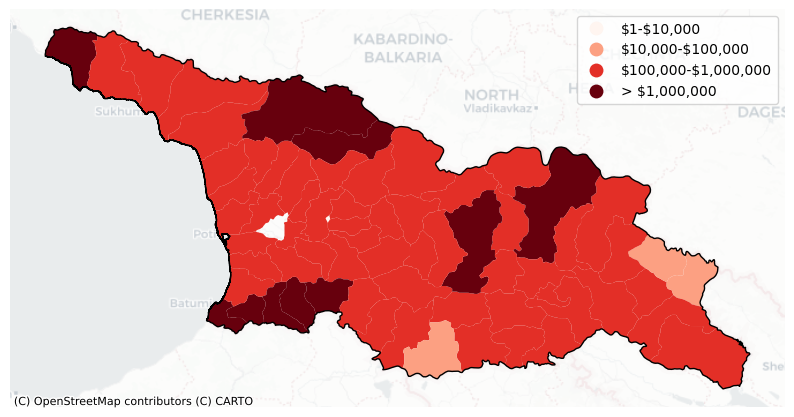

In [132]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,1e5,1e6,subnational_df.ead.max()],labels=['\\$1-$10,000','\\$10,000-$100,000','\\$100,000-$1,000,000','> $1,000,000'])

fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_SSP585_EAD_municipal.png', bbox_inches='tight', dpi=300)

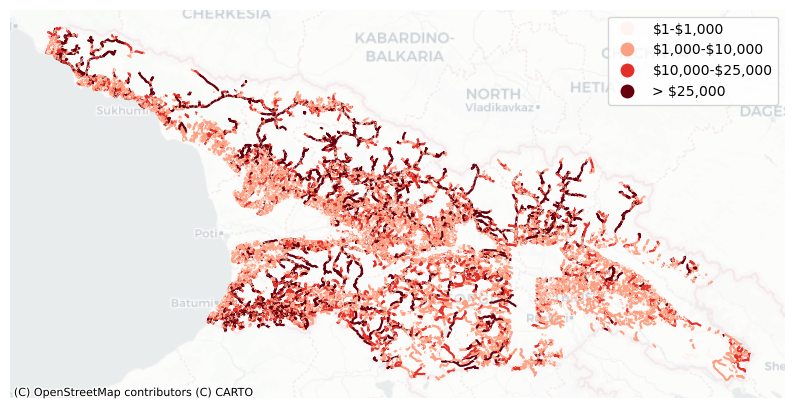

In [135]:
# figure EAD due to rainfall-triggered landslide events due to 25 year RP rainfall: damages per OSM road segment
ead_df['ead_25_binned'] = pd.cut(ead_df['ead_25'],[0,1e3,1e4,2.5e4,ead_df['ead_25'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_25_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

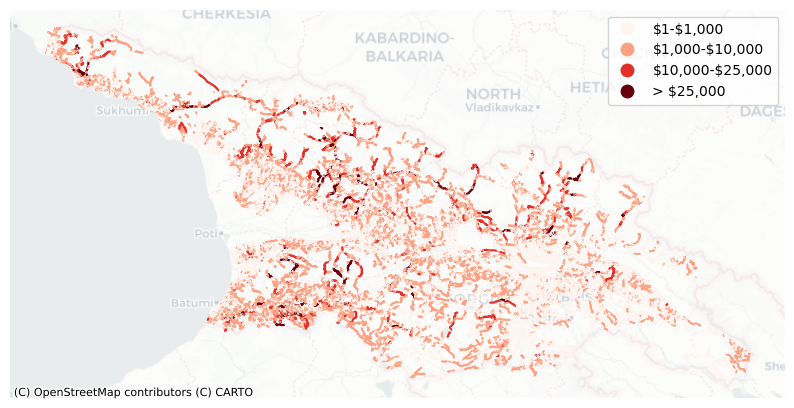

In [136]:
# figure EAD due to rainfall-triggered landslides: damages per OSM road segment
ead_df['ead_binned'] = pd.cut(ead_df['ead'],[0,1e3,1e4,2.5e4,ead_df['ead'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
#subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='ead_binned',cmap='Reds',legend=True,ax=ax)
#damage_df.plot(column ='Partial destruction (0.5)',cmap='Reds',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'landslide_rf_ssp585_EAD.png', bbox_inches='tight', dpi=300)

In [138]:
# exposed roads
print("This is the road length exposed at national level: {:.2f}".format(ead_df.ead_200_overlay.sum()/1000))
print("This is the EAD at national level: {:.2f}".format(ead_df.ead.sum()))

affected_road = ead_df.ead_200_overlay.sum()/1000
damage = ead_df.ead.sum()
print('The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: {:.2f} dollar per km'.format(damage/affected_road))

This is the road length exposed at national level: 35801.47
This is the EAD at national level: 39658192.59
The expected annual damage for Dangara-Gulliston road project, based on length of affected road segment: 1107.73 dollar per km


In [141]:
def read_earthquake_map(earthquake_map_path,bbox,diameter_distance=0.05000000000000000278/2):
     
    # load data from NetCDF file
    with xr.open_dataset(earthquake_map_path) as ds:
        
        # convert data to WGS84 CRS
        ds.rio.write_crs(4326, inplace=True)
        ds = ds.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
        
        ds_vector = ds['band_data'].to_dataframe().reset_index() #transform to dataframe
        
        #remove data that will not be used
        ds_vector = ds_vector.loc[(ds_vector.band_data > 0) & (ds_vector.band_data <= 10)]
        
        # create geometry values and drop lat lon columns
        ds_vector['geometry'] = [shapely.points(x) for x in list(zip(ds_vector['x'],ds_vector['y']))]
        ds_vector = ds_vector.drop(['x','y','band','spatial_ref'],axis=1)

        ds_vector['geometry'] = shapely.buffer(ds_vector.geometry, distance=diameter_distance, cap_style='square').values

        return ds_vector

def h3_to_polygon(h3_index):
    # Get the boundary of the hexagon in (lat, lon) pairs
    boundary = h3.h3_to_geo_boundary(h3_index)
    # Convert to (lon, lat) pairs and create a Polygon
    return shapely.Polygon([(lon, lat) for lat, lon in boundary])

def overlay_hazard_bbox(df_ds,bbox_geometries):
    """
    Overlay hazard assets on a dataframe of spatial geometries.
    Arguments:
        *df_ds*: GeoDataFrame containing the spatial geometries of the hazard data. 
        *boundary*: GeoDataFrame containing the infrastructure assets.
    Returns:
        *geopandas.GeoSeries*: A GeoSeries containing the spatial geometries of df_ds that intersect with the administrative boundary.
    """
    bbox_polygon = shapely.box(*bbox) #create polygon using bbox coordinates
    
    #overlay 
    hazard_tree = shapely.STRtree(df_ds.geometry.values)
    intersect_index = hazard_tree.query(bbox_polygon,predicate='intersects')
    
    return df_ds.iloc[intersect_index].reset_index(drop=True)

def read_earthquake_map_csv(earthquake_map_path,bbox):
    #using h3 geometries: https://pypi.org/project/h3/
    #example Notebooks: https://github.com/uber/h3-py-notebooks
    #more info: https://h3geo.org/docs/quickstart
     
    ds_vector = pd.read_csv(earthquake_map_path)
    for col in ds_vector.columns: 
        if col not in ['lon', 'lat']: ds_vector = ds_vector.rename(columns={col:'band_data'})
    
    #remove data that will not be used
    ds_vector = ds_vector.loc[(ds_vector.band_data > 0) & (ds_vector.band_data <= 10)]

    #create geometry values and drop lat lon columns
    ds_vector['geometry'] = [shapely.points(x) for x in list(zip(ds_vector['lon'],ds_vector['lat']))]
    
    #overlay with bbox
    ds_vector = overlay_hazard_bbox(ds_vector,bbox)
    ds_vector = ds_vector.drop(['geometry'],axis=1)

    #transform to h3 hexagons
    ds_vector['h3_codes'] = ds_vector.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], 6), axis=1) #get h3 code
    ds_vector['geometry'] = ds_vector.apply(lambda row: h3_to_polygon(row['h3_codes']), axis=1) #get hexagon geometries

    #drop columns
    ds_vector = ds_vector.drop(['lon','lat','h3_codes'],axis=1)

    return ds_vector


def create_pathway_dict(data_path, flood_data_path, eq_data_path, landslide_data_path, cyclone_data_path): 

    """
    Create a dictionary containing paths to various hazard datasets.
    Arguments:
        *data_path* (Path): Base directory path for general data.
        *flood_data_path* (Path): Path to flood hazard data.
        *eq_data_path* (Path): Path to earthquake hazard data.
        *landslide_data_path* (Path): Path to landslide hazard data.
        *cyclone_data_path* (Path): Path to tropical cyclone hazard data.
    Returns:
        *dict*: A dictionary where keys represent a general pathway and different hazard types and values are corresponding paths.
    """

    #create a dictionary
    pathway_dict = {'data_path': data_path, 
                    'fluvial': flood_data_path, 
                    'pluvial': flood_data_path, 
                    'windstorm': cyclone_data_path, 
                    'earthquake': eq_data_path, 
                    'landslide_rf': landslide_data_path,
                    'landslide_eq': landslide_data_path,}

    return pathway_dict

def read_hazard_data(hazard_data_path,data_path,hazard_type,ISO3):
    """
    Read hazard data files for a specific hazard type.
    Arguments:
        *hazard_data_path* (Path): Base directory path where hazard data is stored.
        *hazard_type* (str): Type of hazard for which data needs to be read ('fluvial', 'pluvial', 'windstorm', 'earthquake', 'landslide').
    
    Returns:
        *list*: A list of Path objects representing individual hazard data files for the specified hazard type.
    """  

    country_df = pd.read_excel(data_path / 'global_information_advanced_fathom_check.xlsx',sheet_name = 'Sheet1') # finalize this file and adjust name
    fathom_code = country_df.loc[country_df['ISO_3digit'] == country_code, 'Fathom_countries'].item()

    if hazard_type == 'fluvial':
        hazard_data = hazard_data_path / fathom_code / 'fluvial_undefended' 
        return list(hazard_data.iterdir())

    elif hazard_type == 'pluvial':
        hazard_data = hazard_data_path / fathom_code / 'pluvial' 
        return list(hazard_data.iterdir())
    
    elif hazard_type == 'windstorm':
        hazard_data = hazard_data_path 
        return list(hazard_data.iterdir())

    elif hazard_type == 'earthquake':
        if 'GAR' in str(hazard_data_path):
            data_lst = []
            hazard_data = hazard_data_path
            rp_lst = list(hazard_data.iterdir())
            for rp_folder in rp_lst:
                temp_lst = (list(rp_folder.iterdir()))
                data_lst.append([file for file in temp_lst if file.suffix == '.tif'])
            return data_lst
            
        elif 'GEM' in str(hazard_data_path):
            hazard_data = hazard_data_path
            data_lst = list(hazard_data.iterdir())
            data_lst = [file for file in data_lst if file.suffix == '.csv']
            return data_lst

    #elif hazard_type == 'earthquake':
    #    hazard_data = hazard_data_path
    #    return list(hazard_data.iterdir())

    elif hazard_type == 'landslide_rf':
        hazard_data = hazard_data_path / 'rainfall' / '{}_l24-norm-hist.tif'.format(ISO3)
        return [hazard_data]

    elif hazard_type == 'landslide_eq':
        hazard_data = hazard_data_path.parent / 'earthquakes' / 'GEM' / 'GEM-GSHM_PGA-475y-rock_v2023' / 'v2023_1_pga_475_rock_3min.tif' #use only one rp for the triggering conditions
        #hazard_data = hazard_data_path.parent / 'earthquakes' / 'GAR' / 'raw' / 'rp_475'/ 'gar17pga475.tif' #use only one rp for the triggering conditions
        return [hazard_data]

In [145]:
#define paths
p = Path('..')
data_path = Path(pathlib.Path.home().parts[0]) / 'Projects' / 'gmhcira' / 'data' #should contain folder 'Vulnerability' with vulnerability data
flood_data_path = Path(pathlib.Path('Z:') / 'eks510' / 'fathom-global') # Flood data
eq_data_path = Path(pathlib.Path('Z:') / 'data_catalogue' / 'open_street_map' / 'global_hazards' / 'earthquakes' / 'GEM') # Earthquake data
#eq_data_path = Path(pathlib.Path('Z:') / 'data_catalogue' / 'open_street_map' / 'global_hazards' / 'earthquakes' / 'GAR' / 'raw') #eq data GAR
landslide_data_path = Path(pathlib.Path('Z:') / 'data_catalogue' / 'open_street_map' / 'global_hazards' / 'landslides') # Landslide data
cyclone_data_path = Path(pathlib.Path('Z:') / 'data_catalogue' / 'open_street_map' / 'global_hazards' / 'tropical_cyclones') # Cyclone data

pathway_dict = create_pathway_dict(data_path, flood_data_path, eq_data_path, landslide_data_path, cyclone_data_path)
country_code= 'GEO'
hazard_types = ['earthquake'] #['landslide_rf','landslide_eq'] 

for hazard_type in hazard_types:
 
    # read hazard data
    hazard_data_path = pathway_dict[hazard_type]
    data_path = pathway_dict['data_path']
    hazard_data_list = read_hazard_data(hazard_data_path,data_path,hazard_type,country_code)
    if hazard_type in ['pluvial','fluvial','windstorm','landslide_eq','landslide_rf']: hazard_data_list = [file for file in hazard_data_list if file.suffix == '.tif'] #put this code in read hazard data
    
    if hazard_type in ['windstorm','earthquake','landslide_eq','landslide_rf']:
        # load country geometry file and create geometry to clip
        ne_countries = gpd.read_file(data_path / "natural_earth" / "ne_10m_admin_0_countries.shp") #https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
        bbox = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry.envelope.values[0].bounds
        country_border_geometries = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry
        
    collect_output = {}
    for single_footprint in hazard_data_list: #tqdm(hazard_data_list,total=len(hazard_data_list)):


In [144]:
import h3

In [153]:
single_footprint = hazard_data_list[0]

In [152]:
single_footprint

WindowsPath('Z:data_catalogue/open_street_map/global_hazards/earthquakes/GEM/v2023_2_PGA_rock_475.csv')

In [154]:
        hazard_map = read_earthquake_map_csv(single_footprint, bbox) #gem


        gdf = gpd.GeoDataFrame(hazard_map, geometry='geometry')
        gdf = gdf.set_crs(4326, inplace=True)
        
        # Define the output file path
        output_file_path = 'gem2475_GEO.shp'
        
        # Export the GeoDataFrame to a shapefile
        gdf.to_parquet(output_file_path)